## RNN + LSTM

[Code](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20NLP/Recurrent%20Neural%20Networks/IMDB%20Classification/Sequence%20Classification.ipynb)

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import re

import nltk

# nltk.download('stopwords') #Download the NLTK Stopwords
from nltk.corpus import stopwords

stopwords = set(stopwords.words("english"))

## Word Embeddings

In [2]:
path_to_data = "./aclImdb/train"

path_to_pos_folder = os.path.join(path_to_data, "pos")
path_to_neg_folder = os.path.join(path_to_data, "neg")

path_to_pos_txt = [os.path.join(path_to_pos_folder, file) for file in os.listdir(path_to_pos_folder)]
path_to_neg_txt = [os.path.join(path_to_neg_folder, file) for file in os.listdir(path_to_neg_folder)]

training_files = path_to_pos_txt + path_to_neg_txt

all_text = []
len_words = []

for file in tqdm(training_files):
    with open(file, "r", encoding="utf-8") as f:
        text = f.readlines()[0].lower()
        text = re.sub(r"[^\w\s]", "", text)  # Remove All Punctuation
        text = text.split(" ")  # Split by Space
        text = [word for word in text if word not in stopwords]  # Remove Stopwords

        len_words.append(len(text))
        all_text += text

unique_counts = dict(Counter(all_text))
words = sorted([key for key, value in unique_counts.items() if value > 500])

words.append("<unk>")
words.append("<pad>")

word2index = {word: i for i, word in enumerate(words)}
index2word = {i: word for i, word in enumerate(words)}


100%|██████████| 25000/25000 [00:04<00:00, 5590.22it/s]


## IMDB Dataset

In [3]:
class IMDBDataset(Dataset):
    def __init__(self, training_files, word2index, max_seq_length=200):
        self.training_files = training_files
        self.tokenizer = word2index
        self.max_len = max_seq_length

    def __len__(self):
        return len(self.training_files)

    def __getitem__(self, idx):
        path_to_text = self.training_files[idx]
        with open(path_to_text, "r", encoding="utf-8") as f:
            text = f.read()
            text = text.lower()
            text = re.sub(r"[^\w\s]", "", text)
            text = text.split(" ")
            text = [word for word in text if word not in stopwords]
            tokenized = [self.tokenizer.get(word, self.tokenizer["<unk>"]) for word in text]
            sample = torch.tensor(tokenized)

            if len(sample) > self.max_len:
                diff = len(sample) - self.max_len
                start_idx = np.random.randint(0, diff)
                sample = sample[start_idx : start_idx + self.max_len]

            if "neg" in path_to_text:
                label = 0
            else:
                label = 1

            return sample, label


dataset = IMDBDataset(training_files, word2index)


def data_collator(batch):
    texts, labels = [], []
    for text, label in batch:
        texts.append(text)
        labels.append(label)
    label = torch.tensor(labels)
    texts = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=word2index["<pad>"])
    return texts, label


dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=data_collator)

for batch in dataloader:
    print(batch)
    break


(tensor([[990, 990, 990,  ..., 991, 991, 991],
        [896, 990, 990,  ..., 991, 991, 991],
        [990, 990, 372,  ..., 990, 990, 571],
        ...,
        [990, 990,   0,  ..., 991, 991, 991],
        [603, 968, 564,  ..., 991, 991, 991],
        [510, 990, 990,  ..., 991, 991, 991]]), tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0]))


## Embedding

In [4]:
emb = nn.Embedding(5, 3)

print("Embedding Weights")
print(emb.weight)

print("Embedding for Single Sentence")
sentence = torch.tensor([1, 3])  # Sentence words as a list of numbers
print(emb(sentence))
print(emb(sentence).shape)

print("Embedding for Batch Sentence")
batch_sentences = torch.tensor([[1, 3], [1, 3], [1, 3]])
print(emb(batch_sentences))
print(emb(batch_sentences).shape)

Embedding Weights
Parameter containing:
tensor([[-0.7234,  0.5738,  1.0244],
        [ 1.2391, -0.6795, -1.0594],
        [ 1.1159,  0.3037,  0.5159],
        [-0.9267, -0.7451, -2.2276],
        [ 0.0265, -0.5422,  1.5630]], requires_grad=True)
Embedding for Single Sentence
tensor([[ 1.2391, -0.6795, -1.0594],
        [-0.9267, -0.7451, -2.2276]], grad_fn=<EmbeddingBackward0>)
torch.Size([2, 3])
Embedding for Batch Sentence
tensor([[[ 1.2391, -0.6795, -1.0594],
         [-0.9267, -0.7451, -2.2276]],

        [[ 1.2391, -0.6795, -1.0594],
         [-0.9267, -0.7451, -2.2276]],

        [[ 1.2391, -0.6795, -1.0594],
         [-0.9267, -0.7451, -2.2276]]], grad_fn=<EmbeddingBackward0>)
torch.Size([3, 2, 3])


## LSTM

In [5]:
batch_size = 5
sequence_length = 15

input_size = 10
hidden_size = 20
num_layers = 2


lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

rand = torch.rand(batch_size, sequence_length, input_size)
h0 = torch.zeros(num_layers, batch_size, hidden_size)
c0 = torch.zeros(num_layers, batch_size, hidden_size)

output, (hidden, cell) = lstm(rand, (h0, c0))

print(output.shape)
print(hidden.shape)
print(cell.shape)

hidden[-1][0] == output[0][-1]


torch.Size([5, 15, 20])
torch.Size([2, 5, 20])
torch.Size([2, 5, 20])


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

## LSTM Net

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Get the batch size and sequence length from input x
        batch_size, seq_length = x.size()
        # Pass input through the embedding layer
        embeddings = self.embedding(x)
        # Initialize the hidden and cell states for the LSTM
        h0, c0 = self.init_hidden(batch_size)
        # Pass embeddings and initial states through the LSTM
        output, (hn, cn) = self.lstm(embeddings)
        # Get the last hidden state from the LSTM output
        last_hidden = hn[-1]
        # Apply dropout for regularization
        output = self.dropout(last_hidden)
        # Pass through the final fully connected layer
        output = self.fc(output)
        return output

In [7]:
train_dataset = IMDBDataset("./aclImdb/train", word2index)
test_dataset = IMDBDataset("./aclImdb/test", word2index)

In [8]:
DEVICE = "mps:0"

model = LSTMNet(vocab_size=len(word2index), embedding_dim=128, hidden_size=256, num_layers=1, num_classes=2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 15

train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=data_collator)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=data_collator)

In [9]:
def train(model, epochs, optimizer, loss_fn, train_loader, val_loader):
    log_training = {
        "epoch": [],
        "training_loss": [],
        "validation_loss": [],
        "training_acc": [],
        "validation_acc": [],
    }

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []

        model.train()
        for text, label in tqdm(train_loader, desc="Training"):
            text, label = text.to(DEVICE), label.to(DEVICE)

            output = model(text)
            loss = loss_fn(output, label)
            train_losses.append(loss.item())

            # Compute accuracy
            predictions = torch.argmax(output, axis=-1)
            accuracy = (predictions == label).float().mean()
            train_accuracies.append(accuracy.item())

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)

            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        for text, label in tqdm(val_loader, desc="Validation"):
            text, label = text.to(DEVICE), label.to(DEVICE)

            with torch.no_grad():
                output = model(text)
                loss = loss_fn(output, label)
                val_losses.append(loss.item())

                # Compute accuracy
                predictions = torch.argmax(output, axis=-1)
                accuracy = (predictions == label).float().mean()
                val_accuracies.append(accuracy.item())

        training_loss_mean, training_acc_mean = np.mean(train_losses), np.mean(train_accuracies)
        valid_loss_mean, valid_acc_mean = np.mean(val_losses), np.mean(val_accuracies)

        log_training["epoch"].append(epoch)
        log_training["training_loss"].append(training_loss_mean)
        log_training["training_acc"].append(training_acc_mean)
        log_training["validation_loss"].append(valid_loss_mean)
        log_training["validation_acc"].append(valid_acc_mean)

        print("Training Loss:", training_loss_mean)
        print("Training Acc:", training_acc_mean)
        print("Validation Loss:", valid_loss_mean)
        print("Validation Acc:", valid_acc_mean)

    return log_training, model

In [10]:
training_logging, model = train(model, num_epochs, optimizer, loss_fn, train_loader, val_loader)

Epoch 1/15


Validation: 100%|██████████| 782/782 [00:15<00:00, 51.71it/s]


Training Loss: 0.6958525562682725
Training Acc: 0.506074168797954
Validation Loss: 0.6887299750009765
Validation Acc: 0.521699168797954
Epoch 2/15


Validation: 100%|██████████| 782/782 [00:15<00:00, 51.90it/s]


Training Loss: 0.6928406316605981
Training Acc: 0.5229779411764706
Validation Loss: 0.6769226818057277
Validation Acc: 0.5266943734015346
Epoch 3/15


Validation: 100%|██████████| 782/782 [00:12<00:00, 62.78it/s]


Training Loss: 0.6953907064007371
Training Acc: 0.5200607416879796
Validation Loss: 0.6933202647492099
Validation Acc: 0.5063539002557544
Epoch 4/15


Validation: 100%|██████████| 782/782 [00:12<00:00, 62.81it/s]


Training Loss: 0.6547730905015755
Training Acc: 0.5748881074168798
Validation Loss: 0.4513781223341327
Validation Acc: 0.8002317774936062
Epoch 5/15


Validation: 100%|██████████| 782/782 [00:12<00:00, 62.57it/s]


Training Loss: 0.42596024373913055
Training Acc: 0.8155770460358056
Validation Loss: 0.3502280502806387
Validation Acc: 0.8535805626598465
Epoch 6/15


Validation: 100%|██████████| 782/782 [00:14<00:00, 53.79it/s]


Training Loss: 0.3547818728667848
Training Acc: 0.8521419437340153
Validation Loss: 0.29961211197173504
Validation Acc: 0.8738411125319693
Epoch 7/15


Validation: 100%|██████████| 782/782 [00:12<00:00, 63.23it/s]


Training Loss: 0.32119278778391114
Training Acc: 0.8684063299232737
Validation Loss: 0.28281610322368267
Validation Acc: 0.8849104859335039
Epoch 8/15


Validation: 100%|██████████| 782/782 [00:13<00:00, 57.38it/s]


Training Loss: 0.287229545928938
Training Acc: 0.8849504475703325
Validation Loss: 0.22857104236131434
Validation Acc: 0.9092071611253197
Epoch 9/15


Validation: 100%|██████████| 782/782 [00:14<00:00, 54.31it/s]


Training Loss: 0.24797920485401093
Training Acc: 0.9034926470588235
Validation Loss: 0.19341689127656964
Validation Acc: 0.9265105498721228
Epoch 10/15


Validation: 100%|██████████| 782/782 [00:15<00:00, 50.39it/s]


Training Loss: 0.2075276330799398
Training Acc: 0.9223145780051151
Validation Loss: 0.16325478755947573
Validation Acc: 0.9436540920716112
Epoch 11/15


Validation: 100%|██████████| 782/782 [00:14<00:00, 52.61it/s]


Training Loss: 0.16972717590144146
Training Acc: 0.9373001918158568
Validation Loss: 0.1282329970191869
Validation Acc: 0.9592391304347826
Epoch 12/15


Validation: 100%|██████████| 782/782 [00:14<00:00, 52.28it/s]


Training Loss: 0.1402885527219004
Training Acc: 0.9509670716112532
Validation Loss: 0.11951543854744844
Validation Acc: 0.959199168797954
Epoch 13/15


Validation: 100%|██████████| 782/782 [00:12<00:00, 62.53it/s]


Training Loss: 0.12294617655408352
Training Acc: 0.959638746803069
Validation Loss: 0.10185222711909533
Validation Acc: 0.9672714194373402
Epoch 14/15


Validation: 100%|██████████| 782/782 [00:15<00:00, 51.72it/s]


Training Loss: 0.10690568246023582
Training Acc: 0.965712915601023
Validation Loss: 0.07505231191251723
Validation Acc: 0.9772618286445013
Epoch 15/15


Validation: 100%|██████████| 782/782 [00:12<00:00, 62.53it/s]

Training Loss: 0.09832581438605323
Training Acc: 0.9677909207161125
Validation Loss: 0.07460057098642373
Validation Acc: 0.9770220588235294


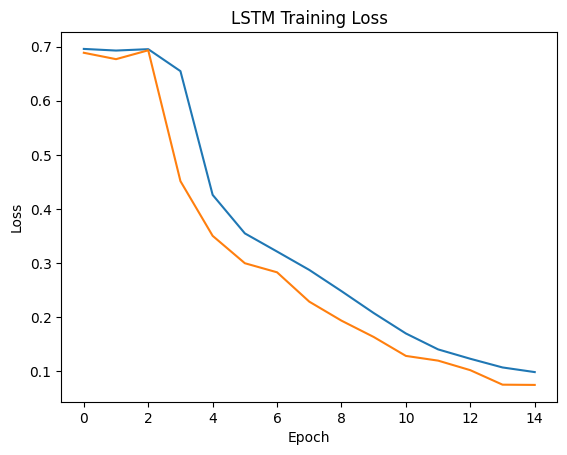

In [11]:
plt.plot(training_logging["training_loss"])
plt.plot(training_logging["validation_loss"])
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()